---
# Executive Summary
* 3x increase in Overall DAU after June 2, 2025 compared to previous period.
* Similarly, 3x increase in Engaged DAU with engaged users holding steady at 63%-66% of Overall DAU.
* Spike in DAU driven by new developers trying Travus API for the first time.
* Since June 2, 2025, product usage retention (# of conversations) based on monthly developer cohorts show directional improvement.
---

In [64]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sqlalchemy import create_engine
import numpy as np

# Connect to database
engine = create_engine("postgresql://dlee@localhost:5432/postgres")

# 1. Daily Active Users (DAU)
* Calculate DAU, clearly specifying your methodology and assumptions.

### Definition of Daily Active Users
* APIs are used by Developers and as a result focusing on developers in users table is a valid approach to isolate daily active users.
* We want to make sure APIs are being used by Developers.
* Based on available data, daily active user is a user with role of a "developer", who generates a conversation session with a valid replica_uuid (this uuid is populated versus NULL) in conversation table regardless of conversation duration. Persona_uuid can be NULL because it has a default persona it might use when a specific persona is not chosen.

### DAU Findings
----
* Before 2025-05-30:
  * **Average DAU: 12.77**
  * Standard Deviation: 9.19
  * Number of days: 146
----
* After 2025-06-02:
  * **Average DAU: 37.34**
  * Standard Deviation: 28.17
  * Number of days: 99
----
* **Difference in Average DAU: 24.57 -> 3x increase**

In [110]:
sql_query_1 = """
SELECT
    t1.created_at::date AS session_date,
    COUNT(CASE WHEN t2.role = 'developer' THEN t1.uuid ELSE NULL END) AS dau
FROM conversation t1
     JOIN (SELECT id, role FROM users WHERE role = 'developer') t2
	 	ON t1.owner_id = t2.id
WHERE t1.replica_uuid IS NOT NULL
GROUP BY 1
ORDER BY 1
"""

# Load data
df1 = pd.read_sql(sql_query_1, engine)
df1['session_date'] = pd.to_datetime(df1['session_date'])

# Split data into before and after periods
before_data = df1[df1['session_date'] < '2025-05-30']
after_data = df1[df1['session_date'] > '2025-06-02']

# Calculate statistics before period
before_avg = before_data['dau'].mean()
before_std = before_data['dau'].std()

# Calculate statistics after period
after_avg = after_data['dau'].mean()
after_std = after_data['dau'].std()

print(f"Before 2025-05-30:")
print(f"  Average DAU: {before_avg:.2f}")
print(f"  Standard Deviation: {before_std:.2f}")
print(f"  Number of days: {len(before_data)}")
print()
print(f"After 2025-06-02:")
print(f"  Average DAU: {after_avg:.2f}")
print(f"  Standard Deviation: {after_std:.2f}")
print(f"  Number of days: {len(after_data)}")
print()
print(f"Difference in Average DAU: {after_avg - before_avg:.2f}")

Before 2025-05-30:
  Average DAU: 12.77
  Standard Deviation: 9.19
  Number of days: 146

After 2025-06-02:
  Average DAU: 37.34
  Standard Deviation: 28.17
  Number of days: 99

Difference in Average DAU: 24.57


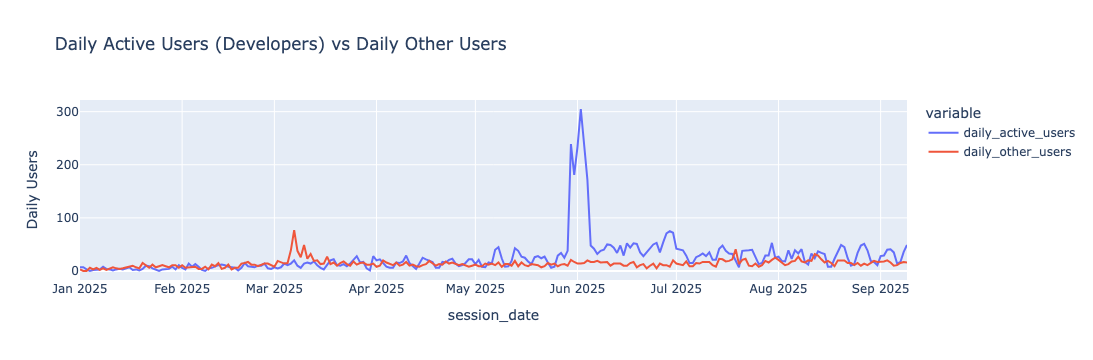

In [113]:
# Daily Active User
sql_query_2 = """
SELECT
	t1.created_at::date AS session_date,
	COUNT(CASE WHEN t2.role = 'developer' THEN t1.uuid ELSE NULL END) AS daily_active_users,
	COUNT(CASE WHEN t2.role != 'developer' THEN t1.uuid ELSE NULL END) AS daily_other_users
FROM conversation t1
     LEFT JOIN users t2
	 	ON t1.owner_id = t2.id
WHERE t1.replica_uuid IS NOT NULL
GROUP BY 1
ORDER BY 1;
"""

# Load data and create line chart
df2a = pd.read_sql(sql_query_2, engine)
fig = px.line(
    df2a, 
    x='session_date', 
    y=['daily_active_users', 'daily_other_users'],
    title="Daily Active Users (Developers) vs Daily Other Users"
)
fig.update_layout(yaxis_title="Daily Users")
fig.show()

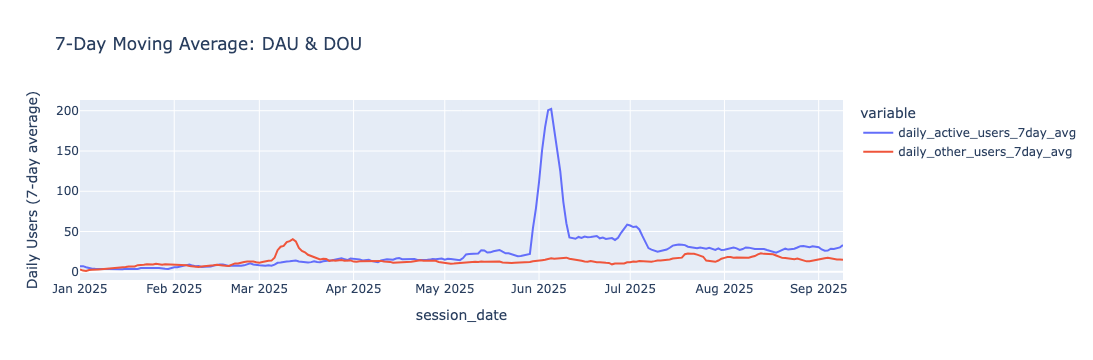

In [129]:
# Calculate 7-day moving averages
df2b = pd.read_sql(sql_query_2, engine)
df2b['daily_active_users_7day_avg'] = df2b['daily_active_users'].rolling(window=7, min_periods=1).mean()
df2b['daily_other_users_7day_avg'] = df2b['daily_other_users'].rolling(window=7, min_periods=1).mean()

# Create line chart with both original and 7-day average data
fig = px.line(
    df2b, 
    x='session_date', 
    y=['daily_active_users_7day_avg', 
       'daily_other_users_7day_avg'],
    title="7-Day Moving Average: DAU & DOU"
)

# Label y-axis as "Daily Users"
fig.update_layout(yaxis_title="Daily Users (7-day average)")
fig.show()

# 2. Engaged Users
* Leadership is specifically interested in users who have conversations lasting at least 1 minute. Conversation length can be calculated as: Conversation Length=Conversation updated_at−Conversation created_at
* Calculate DAU for this engaged segment and highlight any differences from overall DAU trends.

### Definition of Engaged DAU
* DAU + at least one uuid conversation session with duration of 1+ minutes in a day

### Engaged DAU Findings
* After 6/2/2025, engaged DAU increased 3x compared to previous period.
* As a percent of overall DAU, it continues to be approximately 63%-66% before and after.
* A noticeable drop in standard deviation for engaged DAU as a percentage of total overall DAU, which confirms that 63%-66% of total overall DAU is a good indicator of engaged DAU for now.


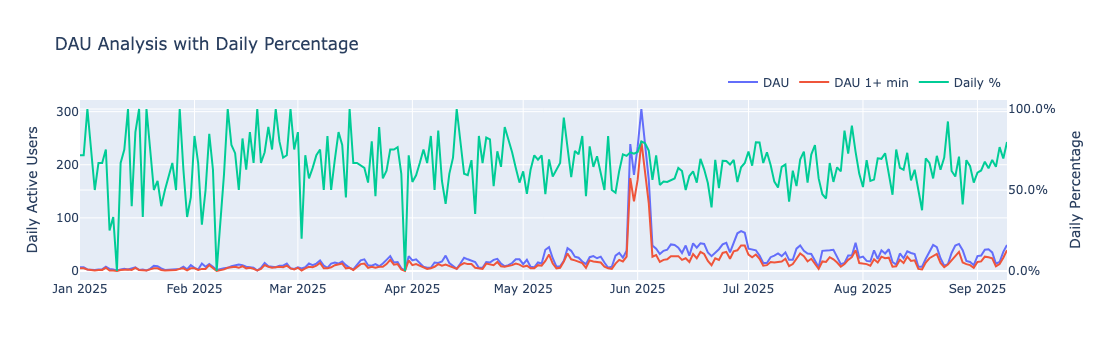

In [120]:
# SQL query
sql_query_3 = """
WITH stg_conversation AS
(
	SELECT
		created_at::date AS session_date,
		uuid,
		owner_id,
		ROUND(EXTRACT(EPOCH FROM (updated_at - created_at)) / 60, 2) AS duration_minutes
	FROM conversation
),
stg_users AS
(
	SELECT id, role
	FROM users
	WHERE role = 'developer'
),
agg_view AS
(
	SELECT
		t1.session_date,
		COUNT(CASE WHEN t2.role = 'developer' THEN t1.uuid ELSE NULL END) AS dau,
		COUNT(CASE WHEN t2.role = 'developer' AND t1.duration_minutes >= 1 THEN t1.uuid ELSE NULL END) AS dau_1_min
	FROM stg_conversation t1
		 JOIN stg_users t2
			ON t1.owner_id = t2.id
	GROUP BY 1
)
SELECT 
	session_date,
	dau,
	dau_1_min,
	ROUND(1.0 * dau_1_min / dau, 4) as daily_percent
FROM agg_view
ORDER BY 1;
"""

df3 = pd.read_sql(sql_query_3, engine)
fig = go.Figure()
fig.add_trace(go.Scatter(x=df3['session_date'], y=df3['dau'], name="DAU"))
fig.add_trace(go.Scatter(x=df3['session_date'], y=df3['dau_1_min'], name="DAU 1+ min"))
fig.add_trace(go.Scatter(x=df3['session_date'], y=df3['daily_percent'], name="Daily %", yaxis="y2"))
fig.update_layout(
    title="DAU Analysis with Daily Percentage",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    yaxis=dict(title="Daily Active Users"),
    yaxis2=dict(title="Daily Percentage", overlaying="y", side="right", tickformat=".1%")
)
fig.show()

In [122]:
# Pre vs Post Average Analysis
df3['session_date'] = pd.to_datetime(df3['session_date'])

# Split data into before and after periods
before_data_3 = df3b[df3['session_date'] < '2025-05-30']
after_data_3 = df3b[df3['session_date'] > '2025-06-02']

# Calculate statistics for DAU
before_dau_avg_3 = before_data_3['dau_1_min'].mean()
before_dau_std_3 = before_data_3['dau_1_min'].std()
after_dau_avg_3 = after_data_3['dau_1_min'].mean()
after_dau_std_3 = after_data_3['dau_1_min'].std()

# Calculate statistics for daily percentage
before_percent_avg_3 = before_data_3['daily_percent'].mean()
before_percent_std_3 = before_data_3['daily_percent'].std()
after_percent_avg_3 = after_data_3['daily_percent'].mean()
after_percent_std_3 = after_data_3['daily_percent'].std()

print("DAU 1+ Min (Engaged) Analysis:")
print("=" * 40)
print(f"Before 2025-05-30:")
print(f"  Average DAU 1+ Min: {before_dau_avg_3:.2f}")
print(f"  Standard Deviation: {before_dau_std_3:.2f}")
print(f"  Number of days: {len(before_data_3)}")
print()
print(f"After 2025-06-02:")
print(f"  Average DAU 1+ Min: {after_dau_avg_3:.2f}")
print(f"  Standard Deviation: {after_dau_std_3:.2f}")
print(f"  Number of days: {len(after_data_3)}")

print("")
print("Daily Percentage Analysis:")
print("=" * 40)
print(f"Before 2025-05-30:")
print(f"  Average Daily %: {before_percent_avg_3*100:.2f}%")
print(f"  Standard Deviation: {before_percent_std_3*100:.2f}%")
print()
print(f"After 2025-06-02:")
print(f"  Average Daily %: {after_percent_avg_3*100:.2f}%")
print(f"  Standard Deviation: {after_percent_std_3*100:.2f}%")

DAU 1+ Min (Engaged) Analysis:
Before 2025-05-30:
  Average DAU 1+ Min: 8.42
  Standard Deviation: 6.15
  Number of days: 146

After 2025-06-02:
  Average DAU 1+ Min: 24.13
  Standard Deviation: 21.71
  Number of days: 99

Daily Percentage Analysis:
Before 2025-05-30:
  Average Daily %: 66.25%
  Standard Deviation: 19.32%

After 2025-06-02:
  Average Daily %: 63.47%
  Standard Deviation: 10.27%


# 3. Propose Additional Metrics
* Define any additional metrics that you believe are meaningful for understanding
the impact of the launch
* Clearly define your metric(s), justify why it is meaningful, and show your
calculation. If your approach relies on data we have not provided, a conceptual
explanation of your methodology is sufficient based on the given DDL.

### Proposed Metric 1: Average session duration per day
* **Definition:** Calculate at the conversation (uuid) session level the duration in minutes and calculate the average for each day. To improve the quality of the metric, outlier detection (IQR) method is applied.
* **Goal:** The goal of the metric is to measure product engagement and measure usage in a meaningful way. In this case, we are correlating product usage by conversation duration with Tavus replica. Also, if the goal is to optimize the conversations to hit a particular time limit or duration, this metric will capture this trend.

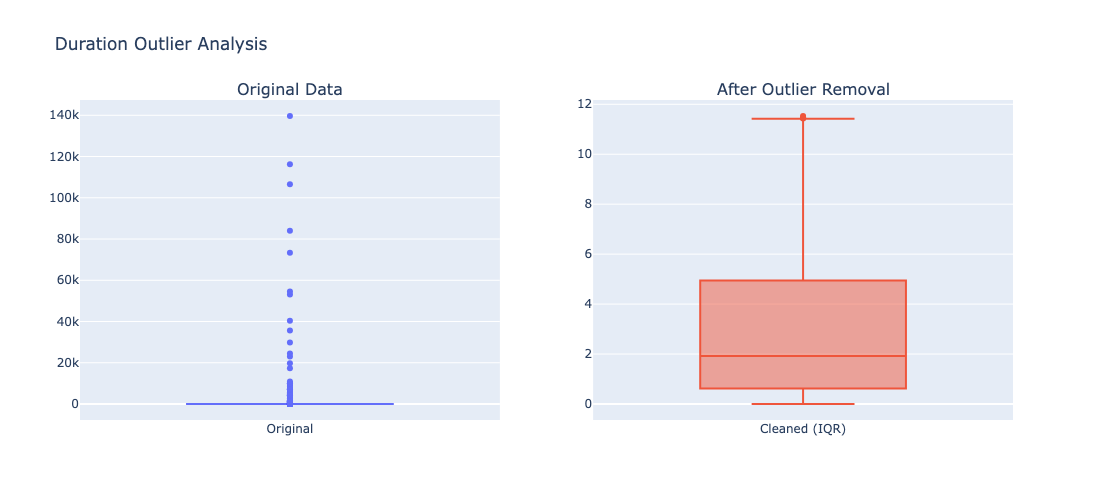

In [128]:
# SQL query
sql_query_4 = """
SELECT 
	t1.created_at::date as session_date,
	t1.uuid,
	ROUND(EXTRACT(EPOCH FROM (t1.updated_at - t1.created_at)) / 60, 2) AS duration_minutes
FROM conversation t1
	 JOIN (SELECT id FROM users WHERE role = 'developer') t2
		ON t1.owner_id = t2.id
"""

# Load data
df4 = pd.read_sql(sql_query_4, engine)

# Outlier detection (IQR method)
Q1 = df4['duration_minutes'].quantile(0.25)
Q3 = df4['duration_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers using IQR method
df_clean = df4[(df4['duration_minutes'] >= lower_bound) & (df4['duration_minutes'] <= upper_bound)]

# Visual new data
fig = make_subplots(rows=1, cols=2, subplot_titles=['Original Data', 'After Outlier Removal'])
fig.add_trace(go.Box(y=df4['duration_minutes'], name='Original', showlegend=False), row=1, col=1)
fig.add_trace(go.Box(y=df_clean['duration_minutes'], name='Cleaned (IQR)', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Duration Outlier Analysis", height=500)
fig.show()

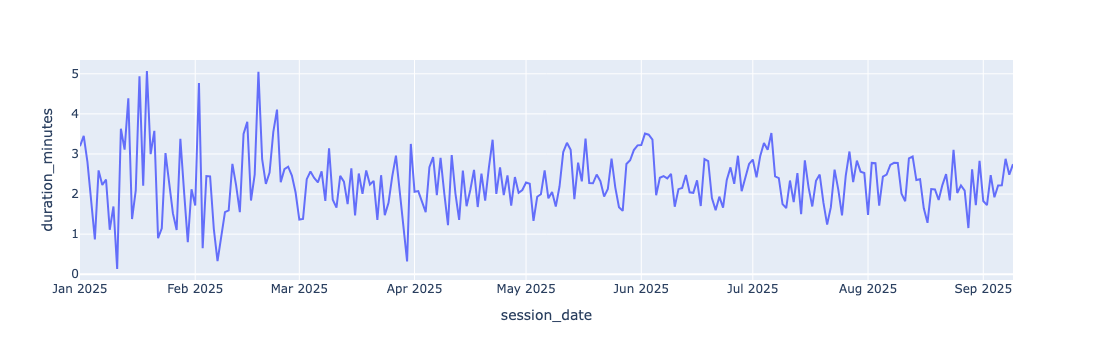

In [86]:
# Calculate daily averages with cleaned dataset
df_daily = df_clean.groupby('session_date')['duration_minutes'].mean().reset_index()
fig = px.line(df_daily, x='session_date', y='duration_minutes')
fig.show()

### Proposed Metric 2: Product Usage Cohort Retention (Based on conversations)

* **Defintion:** Group all developers by their user created month. This initial created month will become month 0. Next, for each cohort, count of the number of conversations by month. For each cohort, the number of conversations in month 0 will become the baseline. Calculate % of baseline for every month going forward.
* **Goal:**
    * Measure developer retention with Tavus API products by counting the number of conversations per month and comparing to each developer's start month (month 0). At a high-level, the product usage retention rate measures if developers are generating more conversations through Tavus APIs compared to their month 0 over time. If they are, then this is a good sign and it means developers are finding value in the product. If the number of conversations fall below the number in Month 0, then it might indicate friction with the product or value prop issue.
    * With this in place you can also measure the lifetime product usage and engagement per developer at the cohort level. You can measure if lifetime product engagement increases or decreases over time.

In [126]:
# Product Usage Cohort Retention Analysis 
sql_query_5 = """
WITH month_series AS 
(
  SELECT 
	TO_CHAR(t1.cohort_date, 'YYYY-MM-01')::date AS cohort_month
  FROM
  (
	  SELECT 
		date_trunc('month', generate_series(
		  (SELECT MIN(created_at) FROM users),
		  (SELECT MAX(created_at) FROM users),
		  interval '1 month'
		)) AS cohort_date
  ) t1
),
stg_users AS
(
	SELECT
		TO_CHAR(created_at, 'YYYY-MM-01')::date AS cohort_month_0,
		id AS user_id,
		created_at AS user_created_at,
		email
	FROM users
	WHERE role = 'developer'
),
stg_conversations AS
(
	SELECT
		owner_id AS user_id,
		uuid AS session_id,
		created_at AS session_created_at,	
		TO_CHAR(created_at, 'YYYY-MM-01')::date AS session_month,
		ROUND(EXTRACT(EPOCH FROM (updated_at - created_at)) / 60, 2) AS duration_minutes
	FROM conversation
	WHERE replica_uuid IS NOT NULL
),
stg_cohorts AS
(
	SELECT
		t1.user_id,
		t1.cohort_month_0,
		t2.session_month,
		COUNT(distinct t2.session_id) AS session_cnt
	FROM stg_users t1
	     LEFT JOIN stg_conversations t2
			ON t1.user_id = t2.user_id
	GROUP BY 1,2,3
),
base_cohort_months AS
(
	SELECT
		t1.user_id,
		t1.cohort_month_0,
		t2.cohort_month,
		ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY t2.cohort_month) AS cohort_period 
	FROM stg_users t1
	     JOIN month_series t2
			ON t1.cohort_month_0 <= t2.cohort_month
),
stg_user_cohort_retention AS
(
	SELECT
		t1.user_id,
		t1.cohort_month_0,
		t1.cohort_month,
		t1.cohort_period - 1 AS cohort_period,
		COALESCE(t2.session_cnt, 0) AS session_cnt
	FROM base_cohort_months t1
	     LEFT JOIN stg_cohorts t2
			ON t1.user_id = t2.user_id
			AND t1.cohort_month = t2.session_month
),
cohort_matrix AS
(
	SELECT
		cohort_month_0,
		SUM(CASE WHEN cohort_period = 0 THEN session_cnt ELSE 0 END) AS month_0,
		SUM(CASE WHEN cohort_period = 1 THEN session_cnt ELSE 0 END) AS month_1,
		SUM(CASE WHEN cohort_period = 2 THEN session_cnt ELSE 0 END) AS month_2,
		SUM(CASE WHEN cohort_period = 3 THEN session_cnt ELSE 0 END) AS month_3,
		SUM(CASE WHEN cohort_period = 4 THEN session_cnt ELSE 0 END) AS month_4,
		SUM(CASE WHEN cohort_period = 5 THEN session_cnt ELSE 0 END) AS month_5,
		SUM(CASE WHEN cohort_period = 6 THEN session_cnt ELSE 0 END) AS month_6,
		SUM(CASE WHEN cohort_period = 7 THEN session_cnt ELSE 0 END) AS month_7,
		SUM(CASE WHEN cohort_period = 8 THEN session_cnt ELSE 0 END) AS month_8,
		SUM(CASE WHEN cohort_period = 9 THEN session_cnt ELSE 0 END) AS month_9,
		SUM(CASE WHEN cohort_period = 10 THEN session_cnt ELSE 0 END) AS month_10,
		SUM(CASE WHEN cohort_period = 11 THEN session_cnt ELSE 0 END) AS month_11,
		SUM(CASE WHEN cohort_period = 12 THEN session_cnt ELSE 0 END) AS month_12
	FROM stg_user_cohort_retention
	WHERE cohort_month_0 >= '2024-08-01'
	GROUP BY 1
)
SELECT
	cohort_month_0 AS "Cohort Month",
	ROUND(100.0 * month_0 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 0",
	ROUND(100.0 * month_1 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 1",
	ROUND(100.0 * month_2 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 2",
	ROUND(100.0 * month_3 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 3",
	ROUND(100.0 * month_4 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 4",
	ROUND(100.0 * month_5 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 5",
	ROUND(100.0 * month_6 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 6",
	ROUND(100.0 * month_7 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 7",
	ROUND(100.0 * month_8 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 8",
	ROUND(100.0 * month_9 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 9",
	ROUND(100.0 * month_10 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 10",
	ROUND(100.0 * month_11 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 11",
	ROUND(100.0 * month_12 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 12"
FROM cohort_matrix
ORDER BY 1;
"""

# Load data
df5 = pd.read_sql(sql_query, engine)
month_cols = [col for col in df5.columns if col.startswith('Month')]
df5.style.format({col: '{:.1f}%' for col in month_cols}).set_properties(**{'font-size': '11px'})

,Cohort Month,Month 0,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11,Month 12
0,2024-08-01,0.0%,0.0%,0.0%,0.0%,0.0%,102973.0%,7102.0%,44172.0%,10581.0%,13809.0%,8226.0%,10797.0%,2800.0%
1,2024-09-01,0.0%,0.0%,0.0%,0.0%,722.0%,1327.0%,4386.0%,373.0%,5347.0%,5076.0%,1088.0%,1232.0%,18.0%
2,2024-10-01,0.0%,0.0%,0.0%,515.0%,15681.0%,13685.0%,430.0%,1813.0%,4113.0%,400.0%,1620.0%,875.0%,0.0%
3,2024-11-01,0.0%,0.0%,13559.0%,1487.0%,382.0%,5378.0%,4650.0%,1603.0%,16427.0%,1758066.0%,1555.0%,0.0%,0.0%
4,2024-12-01,0.0%,21541.0%,8739.0%,10138.0%,3338.0%,6499.0%,1218.0%,6189.0%,8008.0%,118.0%,0.0%,0.0%,0.0%
5,2025-01-01,100.0%,5.0%,2.0%,4.0%,63.0%,4.0%,5.0%,4.0%,0.0%,0.0%,0.0%,0.0%,0.0%
6,2025-02-01,100.0%,15.0%,18.0%,7.0%,19.0%,14.0%,26.0%,1.0%,0.0%,0.0%,0.0%,0.0%,0.0%
7,2025-03-01,100.0%,11.0%,76.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
8,2025-04-01,100.0%,51.0%,0.0%,1.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
9,2025-05-01,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


* User engagement starts to stabilize starting January 2025.
* End of May and early June, we saw an uptick in DAUs, which coincides with new product feature launch, and driven by new users signing up for the company's API.
* We are seeing developers engaging Tavus API much more starting May/June 2025, but retention is looking a bit soft.
* As product usage increase with new features and higher developer engagement, we want to see the numbers generally increase horizontall at the cohort level, and veritcally top to bottom by comparing different cohorts.

### Conversation Duration Cohort Retention
* This metric might not be the best at the moment as the company is focusing on product engagement.
* Same principles as above, but we use duration (in minutes) as our main metric per cohort.
* And as the company matures, we can use revenue to calculate GMV/Revenue retention and LTV per user.

In [127]:
# Conversation Duration Cohort Retention Analysis 
sql_query_6 = """
WITH month_series AS 
(
  SELECT 
	TO_CHAR(t1.cohort_date, 'YYYY-MM-01')::date AS cohort_month
  FROM
  (
	  SELECT 
		date_trunc('month', generate_series(
		  (SELECT MIN(created_at) FROM users),
		  (SELECT MAX(created_at) FROM users),
		  interval '1 month'
		)) AS cohort_date
  ) t1
),
stg_users AS
(
	SELECT
		TO_CHAR(created_at, 'YYYY-MM-01')::date AS cohort_month_0,
		id AS user_id,
		created_at AS user_created_at,
		email
	FROM users
	WHERE role = 'developer'
),
stg_conversations AS
(
	SELECT
		owner_id AS user_id,
		uuid AS session_id,
		created_at AS session_created_at,	
		TO_CHAR(created_at, 'YYYY-MM-01')::date AS session_month,
		ROUND(EXTRACT(EPOCH FROM (updated_at - created_at)) / 60, 2) AS duration_minutes
	FROM conversation
	WHERE replica_uuid IS NOT NULL
),
stg_cohorts AS
(
	SELECT
		t1.user_id,
		t1.cohort_month_0,
		t2.session_month,
		SUM(distinct t2.duration_minutes) AS duration
	FROM stg_users t1
	     LEFT JOIN stg_conversations t2
			ON t1.user_id = t2.user_id
	GROUP BY 1,2,3
),
base_cohort_months AS
(
	SELECT
		t1.user_id,
		t1.cohort_month_0,
		t2.cohort_month,
		ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY t2.cohort_month) AS cohort_period 
	FROM stg_users t1
	     JOIN month_series t2
			ON t1.cohort_month_0 <= t2.cohort_month
),
stg_user_cohort_retention AS
(
	SELECT
		t1.user_id,
		t1.cohort_month_0,
		t1.cohort_month,
		t1.cohort_period - 1 AS cohort_period,
		COALESCE(t2.duration, 0) AS duration
	FROM base_cohort_months t1
	     LEFT JOIN stg_cohorts t2
			ON t1.user_id = t2.user_id
			AND t1.cohort_month = t2.session_month
),
cohort_matrix AS
(
	SELECT
		cohort_month_0,
		SUM(CASE WHEN cohort_period = 0 THEN duration ELSE 0 END) AS month_0,
		SUM(CASE WHEN cohort_period = 1 THEN duration ELSE 0 END) AS month_1,
		SUM(CASE WHEN cohort_period = 2 THEN duration ELSE 0 END) AS month_2,
		SUM(CASE WHEN cohort_period = 3 THEN duration ELSE 0 END) AS month_3,
		SUM(CASE WHEN cohort_period = 4 THEN duration ELSE 0 END) AS month_4,
		SUM(CASE WHEN cohort_period = 5 THEN duration ELSE 0 END) AS month_5,
		SUM(CASE WHEN cohort_period = 6 THEN duration ELSE 0 END) AS month_6,
		SUM(CASE WHEN cohort_period = 7 THEN duration ELSE 0 END) AS month_7,
		SUM(CASE WHEN cohort_period = 8 THEN duration ELSE 0 END) AS month_8,
		SUM(CASE WHEN cohort_period = 9 THEN duration ELSE 0 END) AS month_9,
		SUM(CASE WHEN cohort_period = 10 THEN duration ELSE 0 END) AS month_10,
		SUM(CASE WHEN cohort_period = 11 THEN duration ELSE 0 END) AS month_11,
		SUM(CASE WHEN cohort_period = 12 THEN duration ELSE 0 END) AS month_12
	FROM stg_user_cohort_retention
	WHERE cohort_month_0 >= '2024-08-01'
	GROUP BY 1
)
SELECT
	cohort_month_0 AS "Cohort Month",
	ROUND(100.0 * month_0 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 0",
	ROUND(100.0 * month_1 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 1",
	ROUND(100.0 * month_2 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 2",
	ROUND(100.0 * month_3 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 3",
	ROUND(100.0 * month_4 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 4",
	ROUND(100.0 * month_5 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 5",
	ROUND(100.0 * month_6 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 6",
	ROUND(100.0 * month_7 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 7",
	ROUND(100.0 * month_8 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 8",
	ROUND(100.0 * month_9 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 9",
	ROUND(100.0 * month_10 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 10",
	ROUND(100.0 * month_11 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 11",
	ROUND(100.0 * month_12 / CASE WHEN month_0 = 0 THEN 1 ELSE month_0 END, 0) AS "Month 12"
FROM cohort_matrix
ORDER BY 1;
"""

# Load data
df6 = pd.read_sql(sql_query_6, engine)
month_cols = [col for col in df6.columns if col.startswith('Month')]
df6.style.format({col: '{:.1f}%' for col in month_cols}).set_properties(**{'font-size': '11px'})

,Cohort Month,Month 0,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11,Month 12
0,2024-08-01,0.0%,0.0%,0.0%,0.0%,0.0%,102973.0%,7102.0%,44172.0%,10581.0%,13809.0%,8226.0%,10797.0%,2800.0%
1,2024-09-01,0.0%,0.0%,0.0%,0.0%,722.0%,1327.0%,4386.0%,373.0%,5347.0%,5076.0%,1088.0%,1232.0%,18.0%
2,2024-10-01,0.0%,0.0%,0.0%,515.0%,15681.0%,13685.0%,430.0%,1813.0%,4113.0%,400.0%,1620.0%,875.0%,0.0%
3,2024-11-01,0.0%,0.0%,13559.0%,1487.0%,382.0%,5378.0%,4650.0%,1603.0%,16427.0%,1758066.0%,1555.0%,0.0%,0.0%
4,2024-12-01,0.0%,21541.0%,8739.0%,10138.0%,3338.0%,6499.0%,1218.0%,6189.0%,8008.0%,118.0%,0.0%,0.0%,0.0%
5,2025-01-01,100.0%,5.0%,2.0%,4.0%,63.0%,4.0%,5.0%,4.0%,0.0%,0.0%,0.0%,0.0%,0.0%
6,2025-02-01,100.0%,15.0%,18.0%,7.0%,19.0%,14.0%,26.0%,1.0%,0.0%,0.0%,0.0%,0.0%,0.0%
7,2025-03-01,100.0%,11.0%,76.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
8,2025-04-01,100.0%,51.0%,0.0%,1.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
9,2025-05-01,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
